# Labo 4
Dans ce notebook, nous allons présenter le code que nous avons utiliser, ainsi que les résultas obtenus. Nous afficherons également les différents graphiques obtenus.

## Import des packages et du code

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets
import os
import scipy.io.wavfile as wav
import pandas as pd
from python_speech_features import mfcc

%matplotlib inline

In [3]:
import mlp_backprop_momentum as mlp # Import du code de l'algorithme de MLP avec backpropagation
import k_fold_cross_validation as cv # Import du code de cross-validation

## Dataset
Comme nous allons devoir récupérer tous les fichiers d'une catégories, nous avons créer une fonction qui permet de lire tous les fichiers commençant par un certaine chaine de caractères.

In [4]:
#PATH_DATASET = 'C:/Users/Basile/Documents/Heig-vd/annee_3/MLG/laboratoire/lab04/vowels/'
PATH_DATASET = 'C:/Users/basilechatillon/Documents/Heig-vd/annee_3/MLG/MLG/laboratoire/lab04/vowels/'

In [5]:
def read_wav_file(path, startOfFile=""):
    files = []

    for f in os.listdir(path):
        if startOfFile != "" and f.startswith(startOfFile):
            files.append(wav.read(path + f))

    return files

In [6]:
def analysis_wav_mfcc(wavFiles):
    ceps = []
    
    for wf in wavFiles:
        sample_rate, X = wf
        ceps.append(mfcc(X, samplerate=sample_rate, nfft=1024))
    
    return np.array(ceps)

In [7]:
def mean_of_carac(ceps):
    meanCeps = []
    
    for v in ceps:
        meanCeps.append(np.mean(v, axis=0))
        
    return meanCeps

In [8]:
def data_normalization(dataSet):
    """Normalize the values of the dataSet between [-1, 1]"""
    dMin = dataSet.min(axis=0)
    dMax = dataSet.max(axis=0)
    diff = dMax - dMin
    dataSet = (dataSet - dMin) / diff * 2 - 1
    return dataSet

In [9]:
def f1score(matrix):
    """Compte the f1score for a given confusion matrixtover"""
    tp = 0
    fp = 0
    fn = 0

    for i in range(0, len(matrix)):
        tp += matrix[i, i]
        fp += (matrix[:, i].sum - tp)
        fn += (matrix[i, :].sum - tp)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return 2 * (precision * recall) / (precision + recall)

### Récupération des données et analyse mfcc
Nous maintenant procéder à l'extraction des différentes données qui seront utilisées par la suite

In [10]:
# Rucupération des fichiers
NAMFiles = read_wav_file(PATH_DATASET, "nam") # natural adult male
NAFFiles = read_wav_file(PATH_DATASET, "naf") # natural adult female
SAFFiles = read_wav_file(PATH_DATASET, "saf") # synthesized adult female
NKFiles  = read_wav_file(PATH_DATASET, "nk")  # natural kid
SKFiles  = read_wav_file(PATH_DATASET, "sk")  # synthesized kid
NFiles   = read_wav_file(PATH_DATASET, "n")   # all nuatural voices
SFiles   = read_wav_file(PATH_DATASET, "s")   # all synthesized voices

#Analyse des fichiers grâce à MFCC
NAMCeps = analysis_wav_mfcc(NAMFiles)
NAFCeps = analysis_wav_mfcc(NAFFiles)
SAFCeps = analysis_wav_mfcc(SAFFiles)
NKCeps  = analysis_wav_mfcc(NKFiles)
SKCeps  = analysis_wav_mfcc(SKFiles)
NCeps   = analysis_wav_mfcc(NFiles)
SCeps   = analysis_wav_mfcc(SFiles)

# Pour chaque carac, on fait sa moyenne
NAMMeanCeps = mean_of_carac(NAMCeps)
NAFMeanCeps = mean_of_carac(NAFCeps)
SAFMeanCeps = mean_of_carac(SAFCeps)
NKMeanCeps  = mean_of_carac(NKCeps)
SKMeanCeps  = mean_of_carac(SKCeps)
NMeanCeps   = mean_of_carac(NCeps)
SMeanCeps   = mean_of_carac(SCeps)

# Taille des différents tableaux
sizeNAM = len(NAMMeanCeps)
sizeNAF = len(NAFMeanCeps)
sizeSAF = len(SAFMeanCeps)
sizeNK  = len(NKMeanCeps)
sizeSK  = len(SKMeanCeps)
sizeN   = len(NMeanCeps)
sizeS   = len(SMeanCeps)

## 1. Man vs Woman
*Use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker. *

### Création du dataSet

In [15]:
# Création du dataSet à partir des deux jeux de données
dataSet1Ceps = np.concatenate((NAMMeanCeps, NAFMeanCeps), axis=0)

# normalization du dataSet pour avoir des valeurs entre -1 et 1
dataSet1Normalized = data_normalization(dataSet1Ceps)

# Rajout de la classe à la fin de chaque fichier
resultats = np.ones((dataSet1Normalized.shape[0], 1))
resultats[sizeNAM:, :] = -1

# Ajout au dataSet le classe
dataSet1 = np.concatenate((dataSet1Normalized, resultats), axis=1)

### Exploring the number of epochs

In [16]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

In [17]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet1[:, :13], dataSet1[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


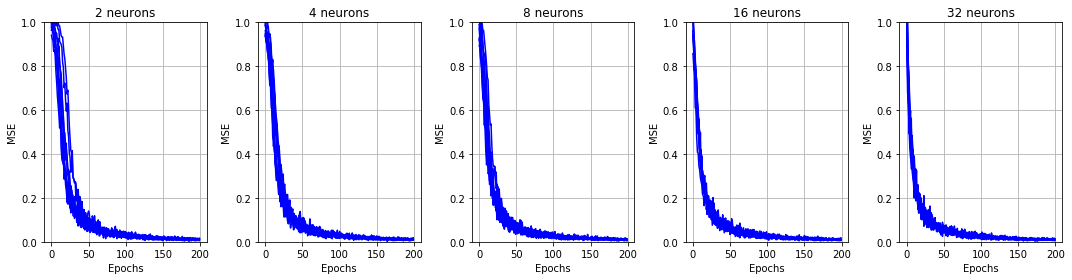

In [18]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [19]:
EPOCHS = 120
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [20]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet1,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


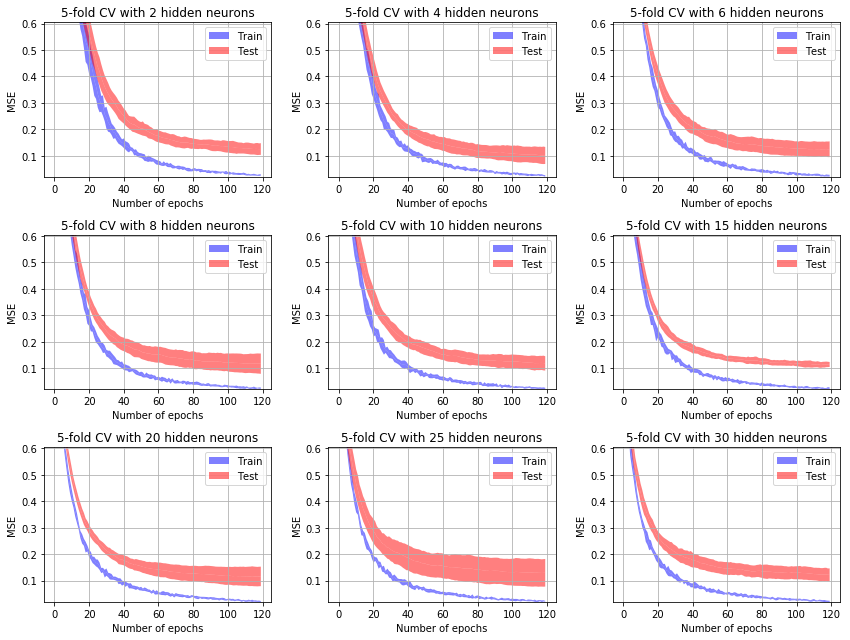

In [23]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.6*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

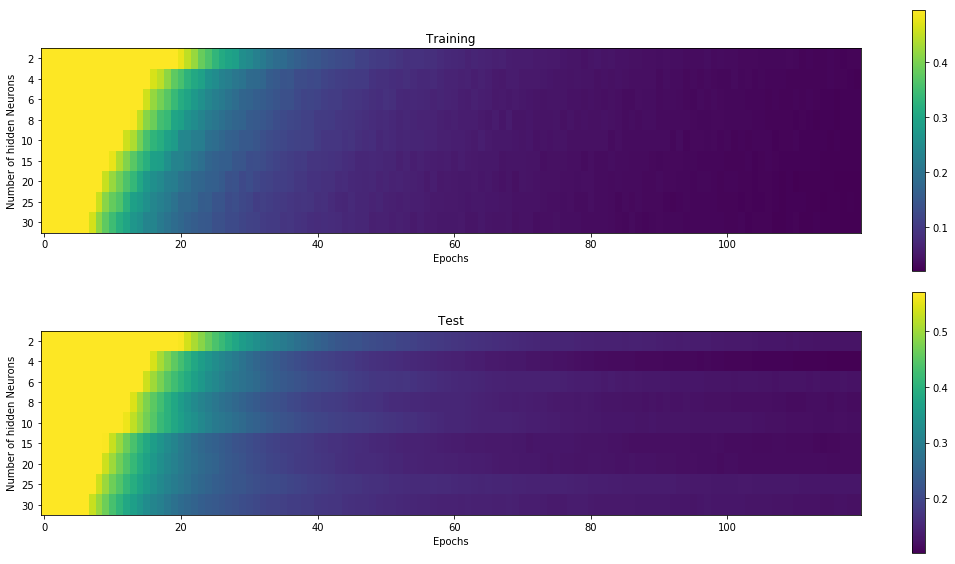

In [24]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [27]:
nn = mlp.MLP([13,4,1], 'tanh')

In [28]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet1,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=100,
                                                          threshold=0.0)

In [29]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.03458650059589008
MSE test:  0.10631268139706322
Confusion matrix:
[[34.  2.]
 [ 0. 36.]]


## 2. Man vs children
*Proceed as explained in 0 but using only man and children voices.*

### Création du dataset


In [30]:
# Création du dataSet à partir des deux jeux de données
dataSet2Ceps = np.concatenate((NAMMeanCeps, NKMeanCeps), axis=0)

# normalisation du dataSet pour avoir des valeurs entre -1 et 1
dataSet2Normalized = data_normalization(dataSet2Ceps)

# Rajout de la classe à la fin de chaque fichier
resultats = np.ones((dataSet2Normalized.shape[0], 1))
resultats[sizeNAM:, :] = -1

# Ajout au dataSet le classe
dataSet2 = np.concatenate((dataSet2Normalized, resultats), axis=1)

### Exploring the number of epochs

In [34]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.005
MOMENTUM = 0.8

In [35]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet2[:, :13], dataSet2[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


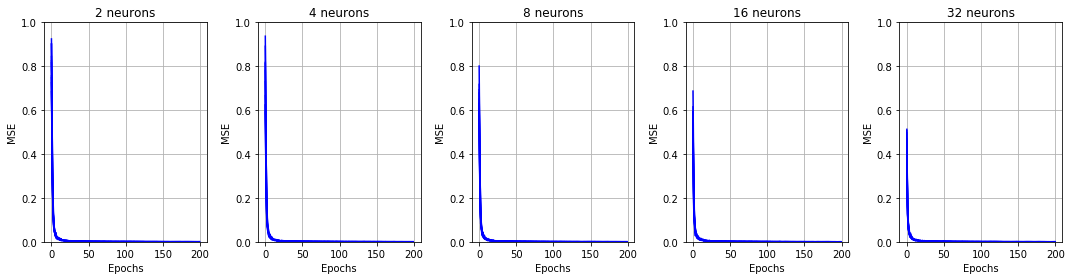

In [36]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [37]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [38]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet2,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


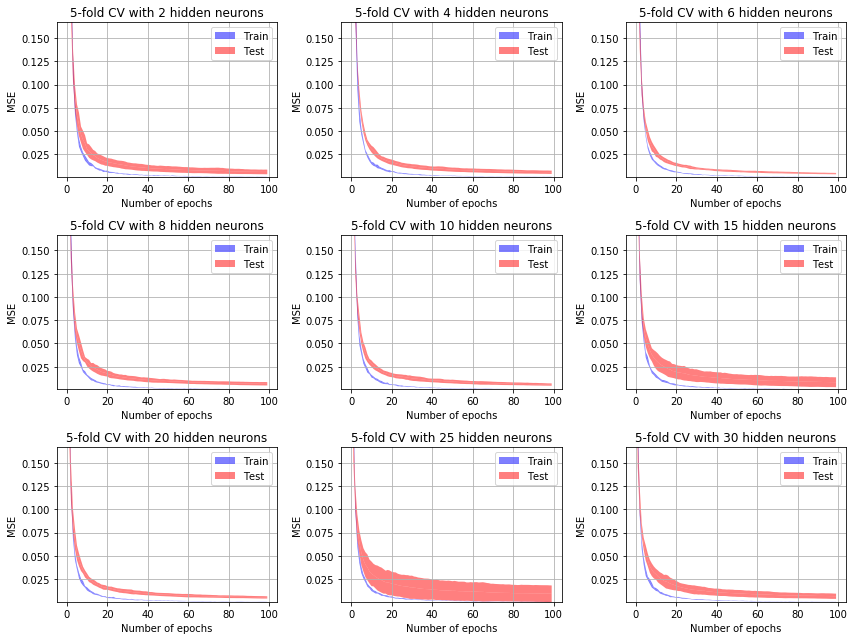

In [42]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

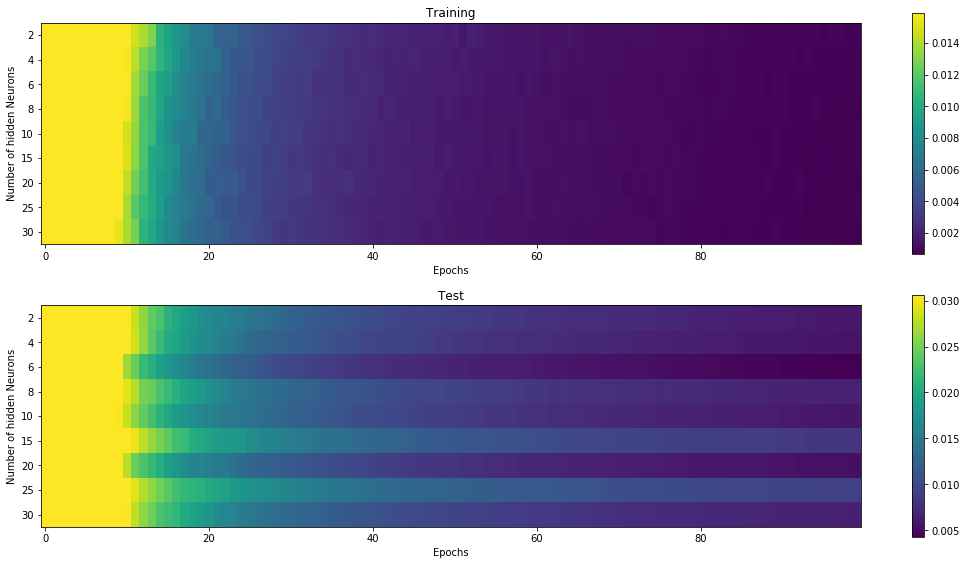

In [43]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [44]:
nn = mlp.MLP([13,6,1], 'tanh')

In [45]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet2,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [46]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.0010188493609876001
MSE test:  0.005023658018314737
Confusion matrix:
[[ 36.   0.]
 [  0. 108.]]


## 3. Woman vs. children
*Proceed as explained in 0 but using only woman and children voices*

### Création du dataset


In [47]:
# Création du dataSet à partir des deux jeux de données
dataSet3Ceps = np.concatenate((NAFMeanCeps, NKMeanCeps), axis=0)

# normalisation du dataSet pour avoir des valeurs entre -1 et 1
dataSet3Normalized = data_normalization(dataSet3Ceps)

# Rajout de la classe à la fin de chaque fichier
resultats = np.ones((dataSet3Normalized.shape[0], 1))
resultats[sizeNAF:, :] = -1

# Ajout au dataSet le classe
dataSet3 = np.concatenate((dataSet3Normalized, resultats), axis=1)

### Exploring the number of epochs

In [57]:
N_INITS = 10
EPOCHS = 300
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.0005
MOMENTUM = 0.35

In [58]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet3[:, :13], dataSet3[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


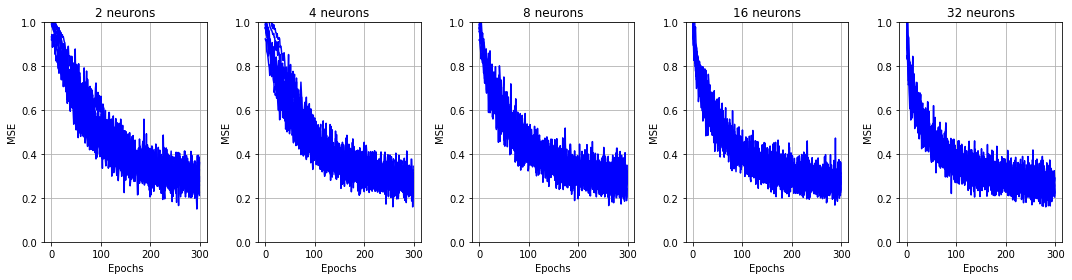

In [60]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [61]:
EPOCHS = 300
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [62]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet3,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


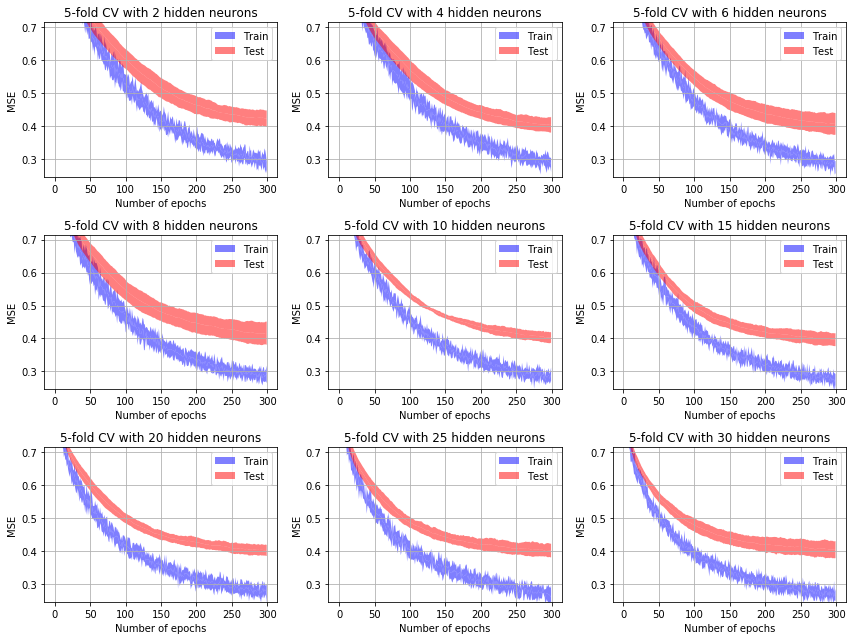

In [64]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.7*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

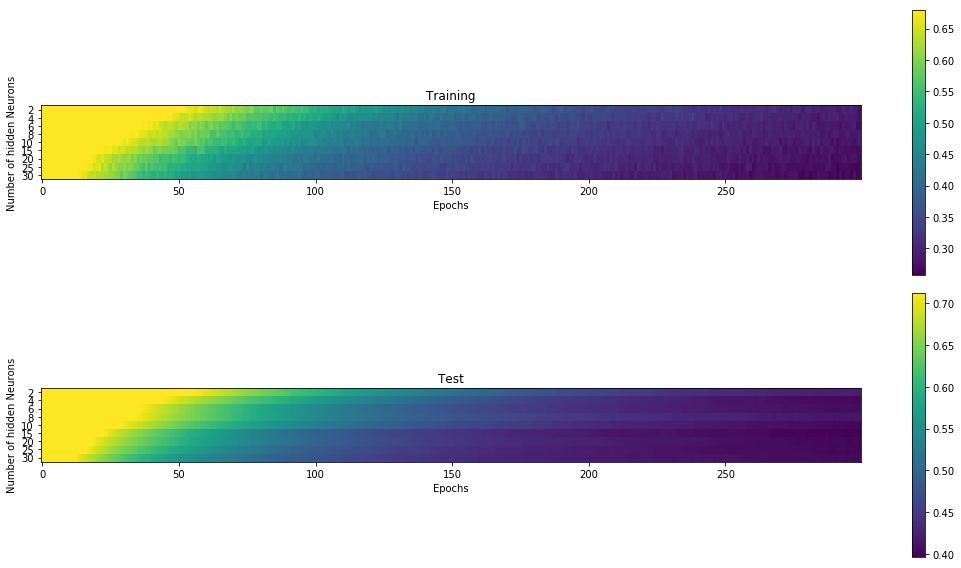

In [65]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [127]:
nn = mlp.MLP([13,10,1], 'tanh')

In [66]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet3,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=300,
                                                          threshold=0.0)

In [129]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.25552703322910186
MSE test:  0.43575698097923404
Confusion matrix:
[[25. 11.]
 [10. 98.]]


## 4. Man vs. Woman vs. children

### Création du dataSet


In [67]:
# Création du dataSet à partir des deux jeux de données
dataSet4Ceps = np.concatenate((np.concatenate((NAMMeanCeps, NAFMeanCeps), axis=0), NKMeanCeps), axis=0)

# normalisation du dataSet pour avoir des valeurs entre -1 et 1
dataSet4Normalized = data_normalization(dataSet4Ceps)


# Rajout de la classe à la fin de chaque fichier
resultats = np.full((dataSet4Normalized.shape[0], 3), -1)
resultats[:sizeNAM, 0] = 1
resultats[sizeNAM:sizeNAM+sizeNAF, 1] = 1
resultats[sizeNAM+sizeNAF:, 2] = 1

# Ajout au dataSet le classe
dataSet4 = np.concatenate((dataSet4Normalized, resultats), axis=1)

### Exploring the number of epochs

In [68]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

In [69]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h, 3], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet4[:, :13], dataSet4[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


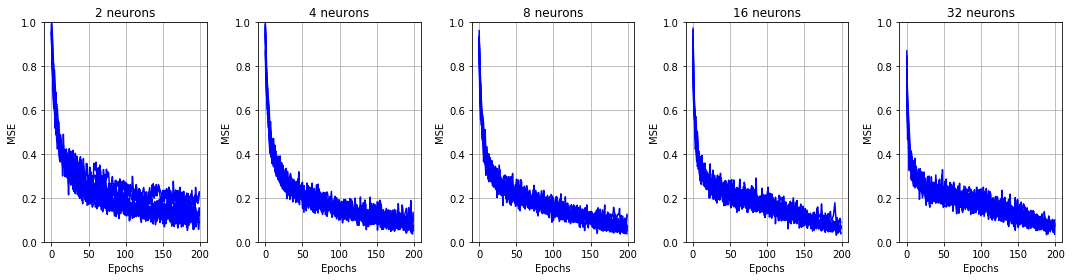

In [70]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [75]:
EPOCHS = 400
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [76]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet4,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


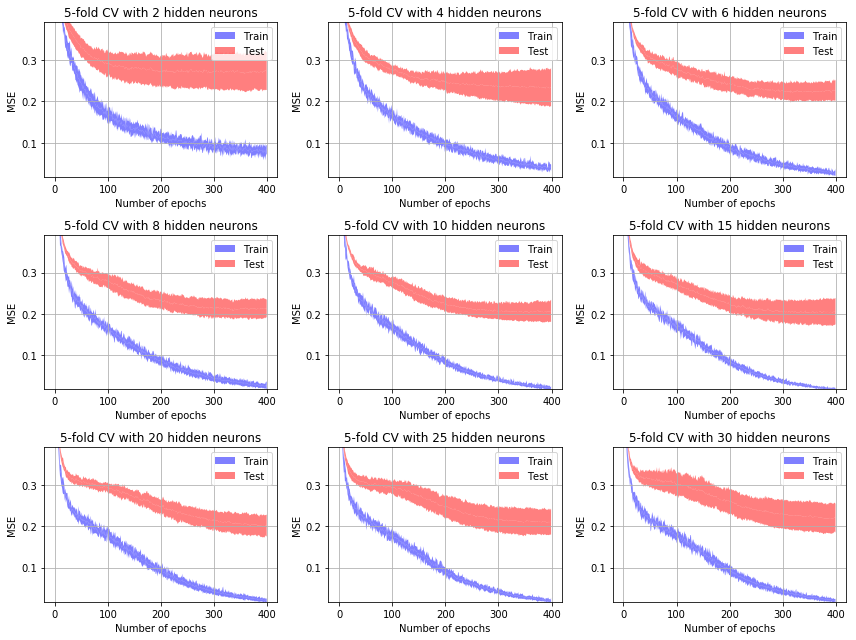

In [77]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.4*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

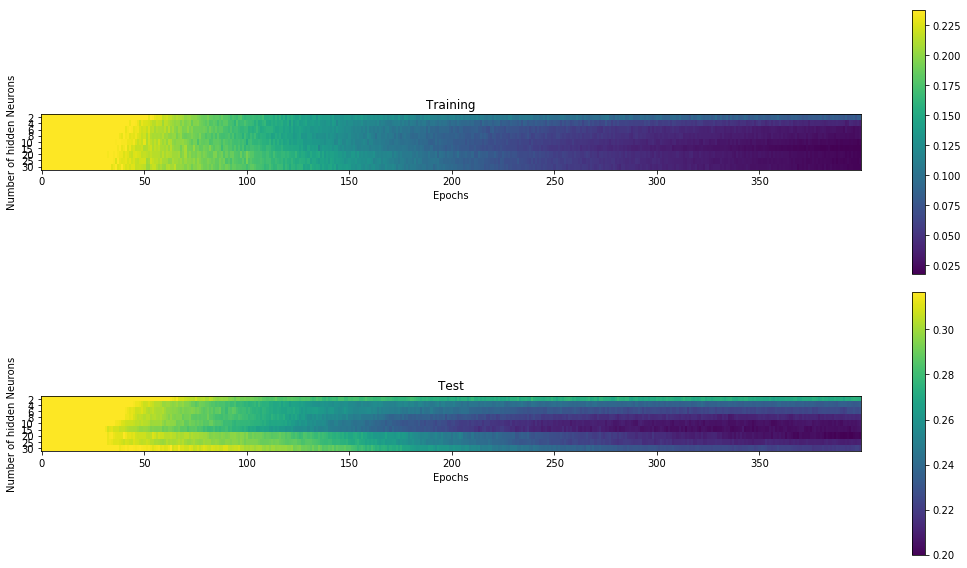

In [78]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [23]:
nn = mlp.MLP([13,20,3], 'tanh')

In [79]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet4,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=400,
                                                          threshold=0.0)

In [80]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.01953157782686136
MSE test:  0.20512376820539968
Confusion matrix:
[[ 34.   2.   0.]
 [  0.  29.   6.]
 [  0.   9. 100.]]


## 5. Natural vs. synthetic voices

### Récupération des données et analyse mfcc


In [81]:
# Création du dataSet à partir des deux jeux de données
dataSet5Ceps = np.concatenate((NMeanCeps, SMeanCeps), axis=0)

# normalisation du dataSet pour avoir des valeurs entre -1 et 1
dataSet5Normalized = data_normalization(dataSet5Ceps)

# Rajout de la classe à la fin de chaque fichier
resultats = np.ones((dataSet5Normalized.shape[0], 1))
resultats[sizeS:, :] = -1

# Ajout au dataSet le classe
dataSet5 = np.concatenate((dataSet5Normalized, resultats), axis=1)

### Exploring the number of epochs

In [82]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

In [83]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet5[:, :13], dataSet5[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


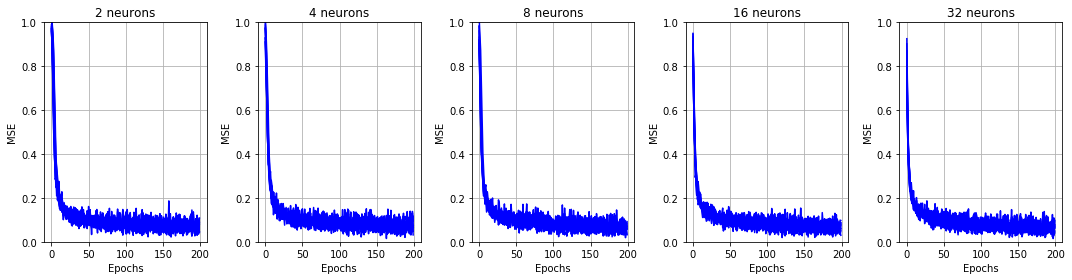

In [85]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [86]:
EPOCHS = 160
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [87]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet5,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


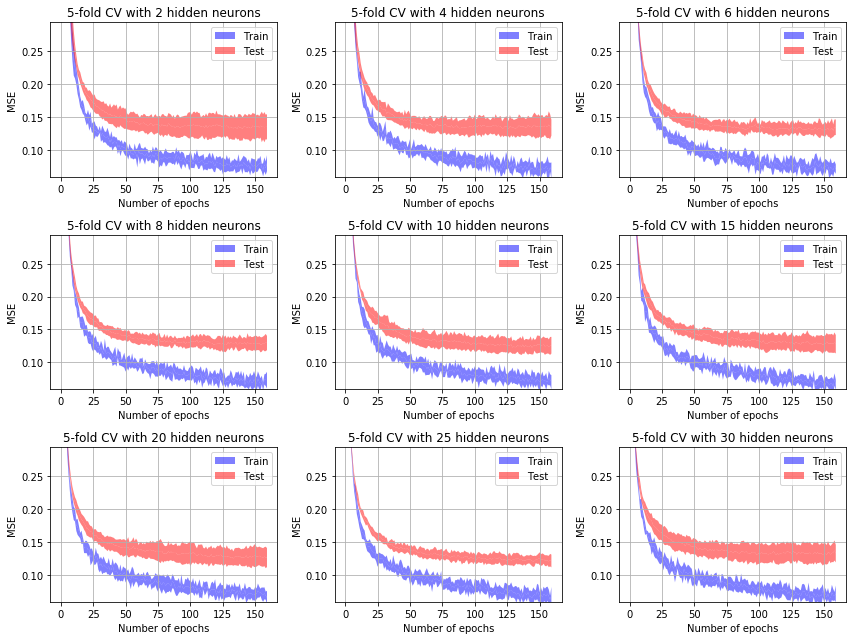

In [90]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.3*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

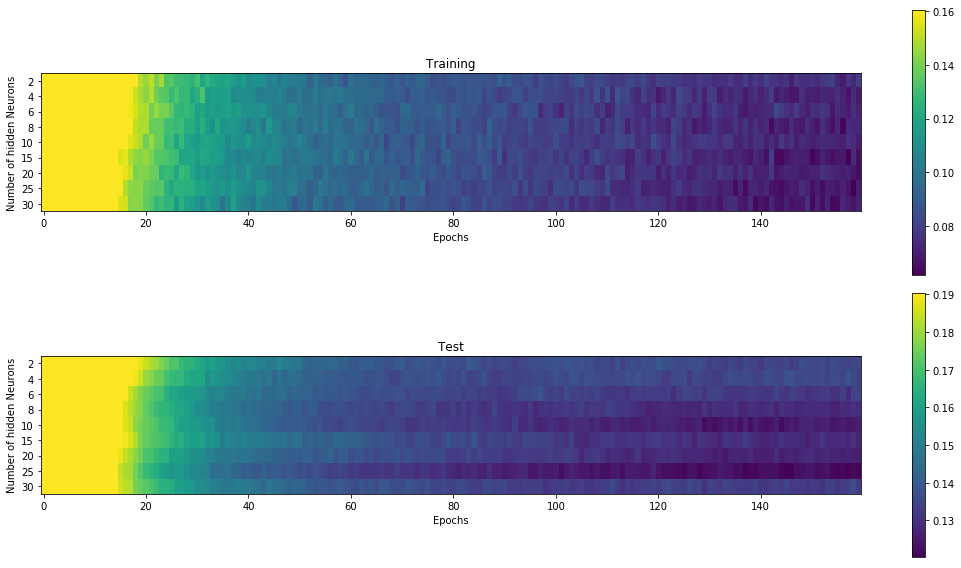

In [91]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [92]:
nn = mlp.MLP([13,25,1], 'tanh')

In [94]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet5,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=120,
                                                          threshold=0.0)

In [95]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.07791891420421575
MSE test:  0.11724865679573852
Confusion matrix:
[[172.   8.]
 [  3. 177.]]


## 6. Design a final experiment of your choice --> synthesized adult female vs synthesized kid

### Récupération des données et analyse mfcc


In [24]:
# Création du dataSet à partir des deux jeux de données
dataSet6Ceps = np.concatenate((SAFMeanCeps, SKMeanCeps), axis=0)

# normalisation du dataSet pour avoir des valeurs entre -1 et 1
dataSet6Normalized = data_normalization(dataSet6Ceps)

# Rajout de la classe à la fin de chaque fichier
resultats = np.ones((dataSet6Normalized.shape[0], 1))
resultats[sizeSAF:, :] = -1

# Ajout au dataSet le classe
dataSet6 = np.concatenate((dataSet6Normalized, resultats), axis=1)

### Exploring the number of epochs

In [38]:
N_INITS = 10
EPOCHS = 400
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.00075
MOMENTUM = 0.35

In [27]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataSet6[:, :13], dataSet6[:, 13:]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing Done!


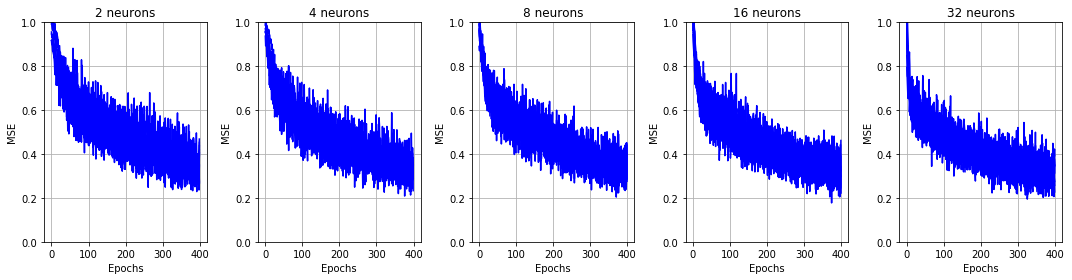

In [28]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

### Exploring the number of hidden neurons


In [34]:
EPOCHS = 500
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [35]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataSet6,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing Done!')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Testing Done!


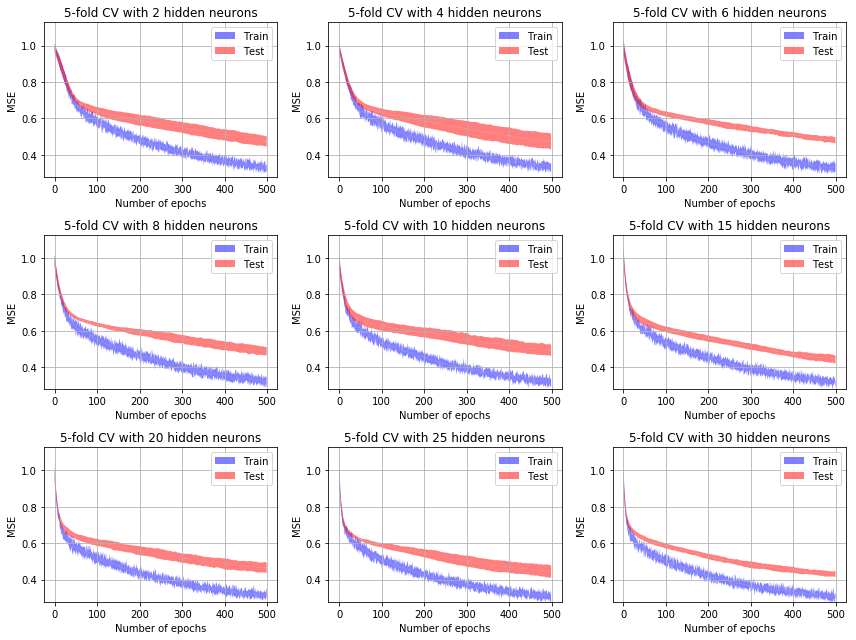

In [36]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.1*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

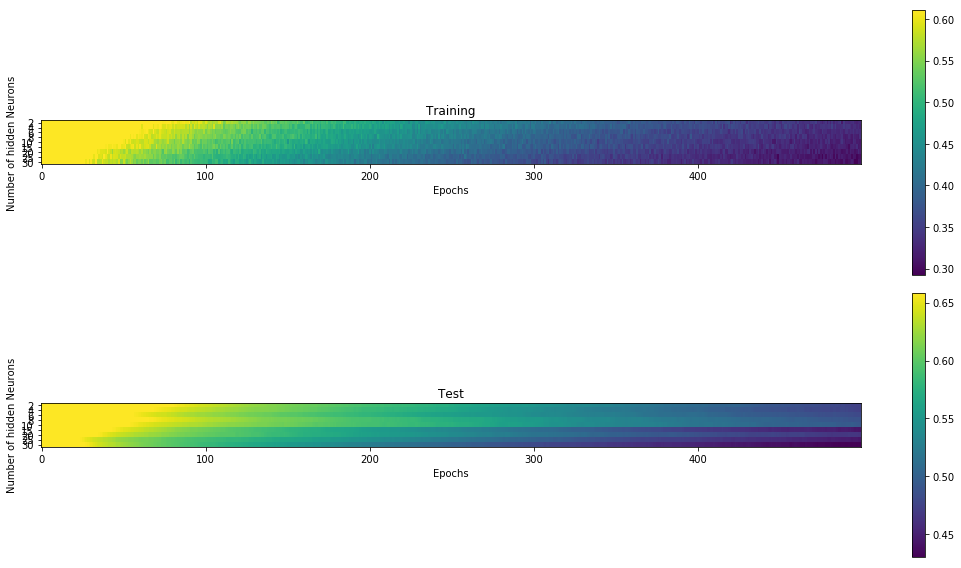

In [37]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### The final model


In [39]:
nn = mlp.MLP([13,30,1], 'tanh')

In [40]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataSet6,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=65,
                                                          threshold=0.0)

In [41]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.49503596215267115
MSE test:  0.5583851033751863
Confusion matrix:
[[ 12.  24.]
 [  7. 101.]]
